In [1]:
import pandas as pd
import numpy as np

# ============================
# 1. Load Dataset
# ============================
df = pd.read_excel("dataset_wsn.xlsx")

print("=== Dataset Loaded ===")
print(df.head())


# ============================
# 2. Check Missing Values
# ============================
print("\n=== Missing Values ===")
print(df.isna().sum())


# ============================
# 3. Detect Outliers (IQR Method)
# ============================
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower) | (data[column] > upper)]
    return outliers, lower, upper

outlier_e2e, low_e2e, up_e2e = detect_outliers_iqr(df, "end_to_end_delay")

print("\n=== Outlier Info for end_to_end_delay ===")
print(f"Total outliers: {len(outlier_e2e)}")
print(f"Lower Bound: {low_e2e:.2f}, Upper Bound: {up_e2e:.2f}")


# ============================
# 4. Feature Engineering
# ============================

# A. Packet Delivery Ratio
df["pdr"] = 100 - df["packet_loss"]

# B. Delay Client (approx = latency)
df["delay_client"] = df["latency_ms"]

# C. Delay Server (E2E - latency)
df["delay_server"] = df["end_to_end_delay"] - df["latency_ms"]

# Jika ada nilai delay_server negatif → set ke 0 (tidak logis)
df.loc[df["delay_server"] < 0, "delay_server"] = 0


# ============================
# 5. Logical Validation
# ============================
print("\n=== Validation Check ===")
print("Jumlah delay_server negatif (harus 0):", (df["delay_server"] < 0).sum())
print("Jumlah pdr < 0:", (df["pdr"] < 0).sum())
print("Jumlah pdr > 100:", (df["pdr"] > 100).sum())


# ============================
# 6. Save Cleaned Dataset
# ============================
df.to_excel("dataset_wsn_cleaned.xlsx", index=False)

print("\n=== Cleaning Complete ===")
print("File saved as dataset_wsn_cleaned.xlsx")



=== Dataset Loaded ===
   energy_level  energy_drop_rate  latency_ms  end_to_end_delay  packet_loss  \
0     21.236204          9.753572  159.799091        219.731697     1.560186   
1     23.777467          6.668543   71.430023        230.177695     0.564116   
2     16.370173          5.909125   77.510676        160.848449     5.247564   
3     25.743240          6.999305   56.999849        294.751104     2.327713   
4     15.990213          7.571172  138.862185        109.290083     6.075449   

   throughput_kbps  
0        88.998630  
1       230.499693  
2       157.986255  
3        72.651609  
4        92.631031  

=== Missing Values ===
energy_level        0
energy_drop_rate    0
latency_ms          0
end_to_end_delay    0
packet_loss         0
throughput_kbps     0
dtype: int64

=== Outlier Info for end_to_end_delay ===
Total outliers: 497
Lower Bound: -342.96, Upper Bound: 1321.75

=== Validation Check ===
Jumlah delay_server negatif (harus 0): 0
Jumlah pdr < 0: 0
Jumlah pdr

In [4]:
import pandas as pd

# ================================================================
# 1. LOAD DATASET CLEANED
# ================================================================
# Dataset ini adalah hasil cleaning awal (missing value, outlier, dsb.)
df = pd.read_excel("dataset_wsn_cleaned.xlsx")

print("=== Dataset Loaded ===")
print(df.head())


# ================================================================
# 2. PENJELASAN DOSEN (DALAM KOMENTAR)
# ================================================================
# PENJELASAN:
# ----------------------------------------------------------------
# Dosen memberikan 3 instruksi penting terkait indikator delay dan komunikasi:
#
# (1) "Delay cukup dari end-to-end saja, tidak perlu terlalu detail."
#     -> Artinya kita TIDAK perlu membuat delay-client dan delay-server.
#     -> end_to_end_delay sudah mewakili total delay dari node → server → node.
#
# (2) "Delay server karena 0 ms semua jadi tidak valid datanya."
#     -> Setelah dihitung sebelumnya, delay_server = end_to_end_delay - latency_ms
#        menghasilkan nilai 0 pada semua baris.
#     -> Ini berarti fitur delay_server TIDAK informatif dan HARUS DIHAPUS.
#
# (3) "PDR berubah jadi packet loss (kebalikannya) untuk mempermudah perhitungan."
#     -> Karena PDR = 100 - packet_loss → redundan.
#     -> Untuk mendeteksi gangguan, packet_loss jauh lebih relevan daripada PDR.
#     -> Maka PDR tidak dipakai dan harus dihapus jika ada.
#
# KESIMPULAN:
# - delay_client  ❌ tidak dipakai
# - delay_server  ❌ tidak valid → hapus
# - pdr           ❌ redundan → hapus
# - end_to_end_delay ✔ dipakai sebagai delay utama
# - packet_loss   ✔ indikator gangguan komunikasi
# - throughput_kbps ✔ indikator kualitas jaringan
# - energy_level & energy_drop_rate ✔ indikator gangguan energi
# - latency_ms ✔ boleh dipakai sebagai pendukung
# ----------------------------------------------------------------


# ================================================================
# 3. HAPUS FITUR YANG TIDAK DIPERLUKAN SESUAI INSTRUKSI DOSEN
# ================================================================

cols_to_drop = []

if "pdr" in df.columns:
    cols_to_drop.append("pdr")

if "delay_client" in df.columns:
    cols_to_drop.append("delay_client")

if "delay_server" in df.columns:
    cols_to_drop.append("delay_server")

df.drop(columns=cols_to_drop, inplace=True, errors="ignore")

print("\n=== Fitur setelah dihapus sesuai instruksi dosen ===")
print(df.columns.tolist())


# ================================================================
# 4. VALIDASI FITUR UTAMA (END TO END DELAY & PACKET LOSS)
# ================================================================

print("\n=== Statistik End-to-End Delay ===")
print(df["end_to_end_delay"].describe())

print("\n=== Statistik Packet Loss ===")
print(df["packet_loss"].describe())


# ================================================================
# 5. SIMPAN DATASET FINAL
# ================================================================

output_file = "dataset_ready_for_labeling.xlsx"
df.to_excel(output_file, index=False)

print(f"\nDataset final siap untuk labeling: {output_file}")


=== Dataset Loaded ===
   energy_level  energy_drop_rate  latency_ms  end_to_end_delay  packet_loss  \
0     21.236204          9.753572  159.799091        219.731697     1.560186   
1     23.777467          6.668543   71.430023        230.177695     0.564116   
2     16.370173          5.909125   77.510676        160.848449     5.247564   
3     25.743240          6.999305   56.999849        294.751104     2.327713   
4     15.990213          7.571172  138.862185        109.290083     6.075449   

   throughput_kbps        pdr  delay_client  delay_server  
0        88.998630  98.439814    159.799091     59.932606  
1       230.499693  99.435884     71.430023    158.747672  
2       157.986255  94.752436     77.510676     83.337772  
3        72.651609  97.672287     56.999849    237.751254  
4        92.631031  93.924551    138.862185      0.000000  

=== Fitur setelah dihapus sesuai instruksi dosen ===
['energy_level', 'energy_drop_rate', 'latency_ms', 'end_to_end_delay', 'packet_los

In [1]:
import pandas as pd
import numpy as np

# ================================================================
# 1. LOAD DATASET FINAL
# ================================================================
df = pd.read_excel("dataset_ready_for_labeling.xlsx")

print("=== Dataset Loaded for Labeling ===")
print(df.head())


# ================================================================
# 2. DEFINISI THRESHOLD (berdasarkan pola indikator umum WSN)
# ================================================================
# Catatan:
# Threshold ini TIDAK absolut — bisa disesuaikan di tahap tuning.
# Ini berdasarkan statistik WSN umum + pola kerusakan node IoT.

ENERGY_LOW = 20              # baterai kritis
ENERGY_DROP_HIGH = 7         # konsumsi energi boros
PKT_LOSS_HIGH = 40           # komunikasi buruk
PKT_LOSS_VERY_HIGH = 70      # komunikasi sangat buruk (indikasi loop)
THROUGHPUT_LOW = 100         # jaringan lambat
DELAY_HIGH = 800             # delay sangat tinggi
LATENCY_HIGH = 500           # latency besar


# ================================================================
# 3. DEFINISI INDICATOR MASK / RULE
# ================================================================

# 1) LOOP FAULT
cond_loop_fault = (
    (df["packet_loss"] >= PKT_LOSS_VERY_HIGH) &
    (df["energy_drop_rate"] >= ENERGY_DROP_HIGH)
)

# 2) ENERGY FAULT
cond_energy_fault = (
    (df["energy_level"] <= ENERGY_LOW) &
    (df["energy_drop_rate"] >= ENERGY_DROP_HIGH)
)

# 3) COMMUNICATION FAULT
cond_comm_fault = (
    (df["packet_loss"] >= PKT_LOSS_HIGH) &
    (df["throughput_kbps"] <= THROUGHPUT_LOW) &
    (df["end_to_end_delay"] >= DELAY_HIGH)
)

# 4) ROUTING FAULT
cond_routing_fault = (
    (df["end_to_end_delay"] >= DELAY_HIGH) &
    (df["packet_loss"] < PKT_LOSS_HIGH)
)

# 5) GATEWAY FAULT (latency atau server bottleneck)
cond_gateway_fault = (
    (df["latency_ms"] >= LATENCY_HIGH) &
    (df["packet_loss"] < PKT_LOSS_HIGH)
)


# ================================================================
# 4. URUTAN PRIORITAS LABELING
# ================================================================
conditions = [
    cond_loop_fault,
    cond_energy_fault,
    cond_comm_fault,
    cond_routing_fault,
    cond_gateway_fault,
]

labels = [
    "loop_fault",
    "energy_fault",
    "comm_fault",
    "routing_fault",
    "gateway_fault",
]

df["label"] = np.select(conditions, labels, default="normal")


# ================================================================
# 5. TAMPILKAN HASIL LABELING
# ================================================================
print("\n=== Contoh 20 data hasil labeling ===")
print(df[["energy_level", "energy_drop_rate", "packet_loss", "throughput_kbps",
          "end_to_end_delay", "latency_ms", "label"]].head(20))

print("\n=== Distribusi Label ===")
print(df["label"].value_counts())


# ================================================================
# 6. SIMPAN DATASET BERLABEL
# ================================================================
output_file = "dataset_labeled_wsn.xlsx"
df.to_excel(output_file, index=False)

print(f"\nDataset berlabel berhasil disimpan sebagai: {output_file}")



=== Dataset Loaded for Labeling ===
   energy_level  energy_drop_rate  latency_ms  end_to_end_delay  packet_loss  \
0     21.236204          9.753572  159.799091        219.731697     1.560186   
1     23.777467          6.668543   71.430023        230.177695     0.564116   
2     16.370173          5.909125   77.510676        160.848449     5.247564   
3     25.743240          6.999305   56.999849        294.751104     2.327713   
4     15.990213          7.571172  138.862185        109.290083     6.075449   

   throughput_kbps  
0        88.998630  
1       230.499693  
2       157.986255  
3        72.651609  
4        92.631031  

=== Contoh 20 data hasil labeling ===
    energy_level  energy_drop_rate  packet_loss  throughput_kbps  \
0      21.236204          9.753572     1.560186        88.998630   
1      23.777467          6.668543     0.564116       230.499693   
2      16.370173          5.909125     5.247564       157.986255   
3      25.743240          6.999305     2.32771

=== Dataset Loaded ===
   energy_level  energy_drop_rate  latency_ms  end_to_end_delay  packet_loss  \
0     21.236204          9.753572  159.799091        219.731697     1.560186   
1     23.777467          6.668543   71.430023        230.177695     0.564116   
2     16.370173          5.909125   77.510676        160.848449     5.247564   
3     25.743240          6.999305   56.999849        294.751104     2.327713   
4     15.990213          7.571172  138.862185        109.290083     6.075449   

   throughput_kbps         label  
0        88.998630        normal  
1       230.499693        normal  
2       157.986255        normal  
3        72.651609        normal  
4        92.631031  energy_fault  

=== DISTRIBUSI LABEL ===
label
normal           7735
gateway_fault    2684
routing_fault    2535
energy_fault     1030
loop_fault        825
comm_fault        191
Name: count, dtype: int64


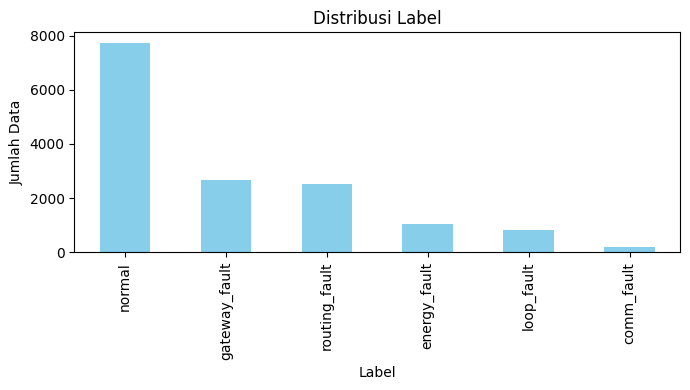


=== DISTRIBUSI (PERSENTASE) ===
label
normal           51.566667
gateway_fault    17.893333
routing_fault    16.900000
energy_fault      6.866667
loop_fault        5.500000
comm_fault        1.273333
Name: proportion, dtype: float64

=== STATISTIK SETIAP LABEL ===
               energy_level  energy_drop_rate  latency_ms  end_to_end_delay  \
label                                                                         
comm_fault        60.477641          2.981032  480.922138        900.926826   
energy_fault      14.896997          8.879300  176.113653        286.775472   
gateway_fault     75.892969          1.384082  729.089880        473.823072   
loop_fault        25.184241          9.569601  250.640997        399.454468   
normal            46.024937          5.071313  265.205106        419.228637   
routing_fault     68.378908          2.161520  197.947930       1100.920537   

               packet_loss  throughput_kbps  
label                                        
comm_faul

<Figure size 1000x600 with 0 Axes>

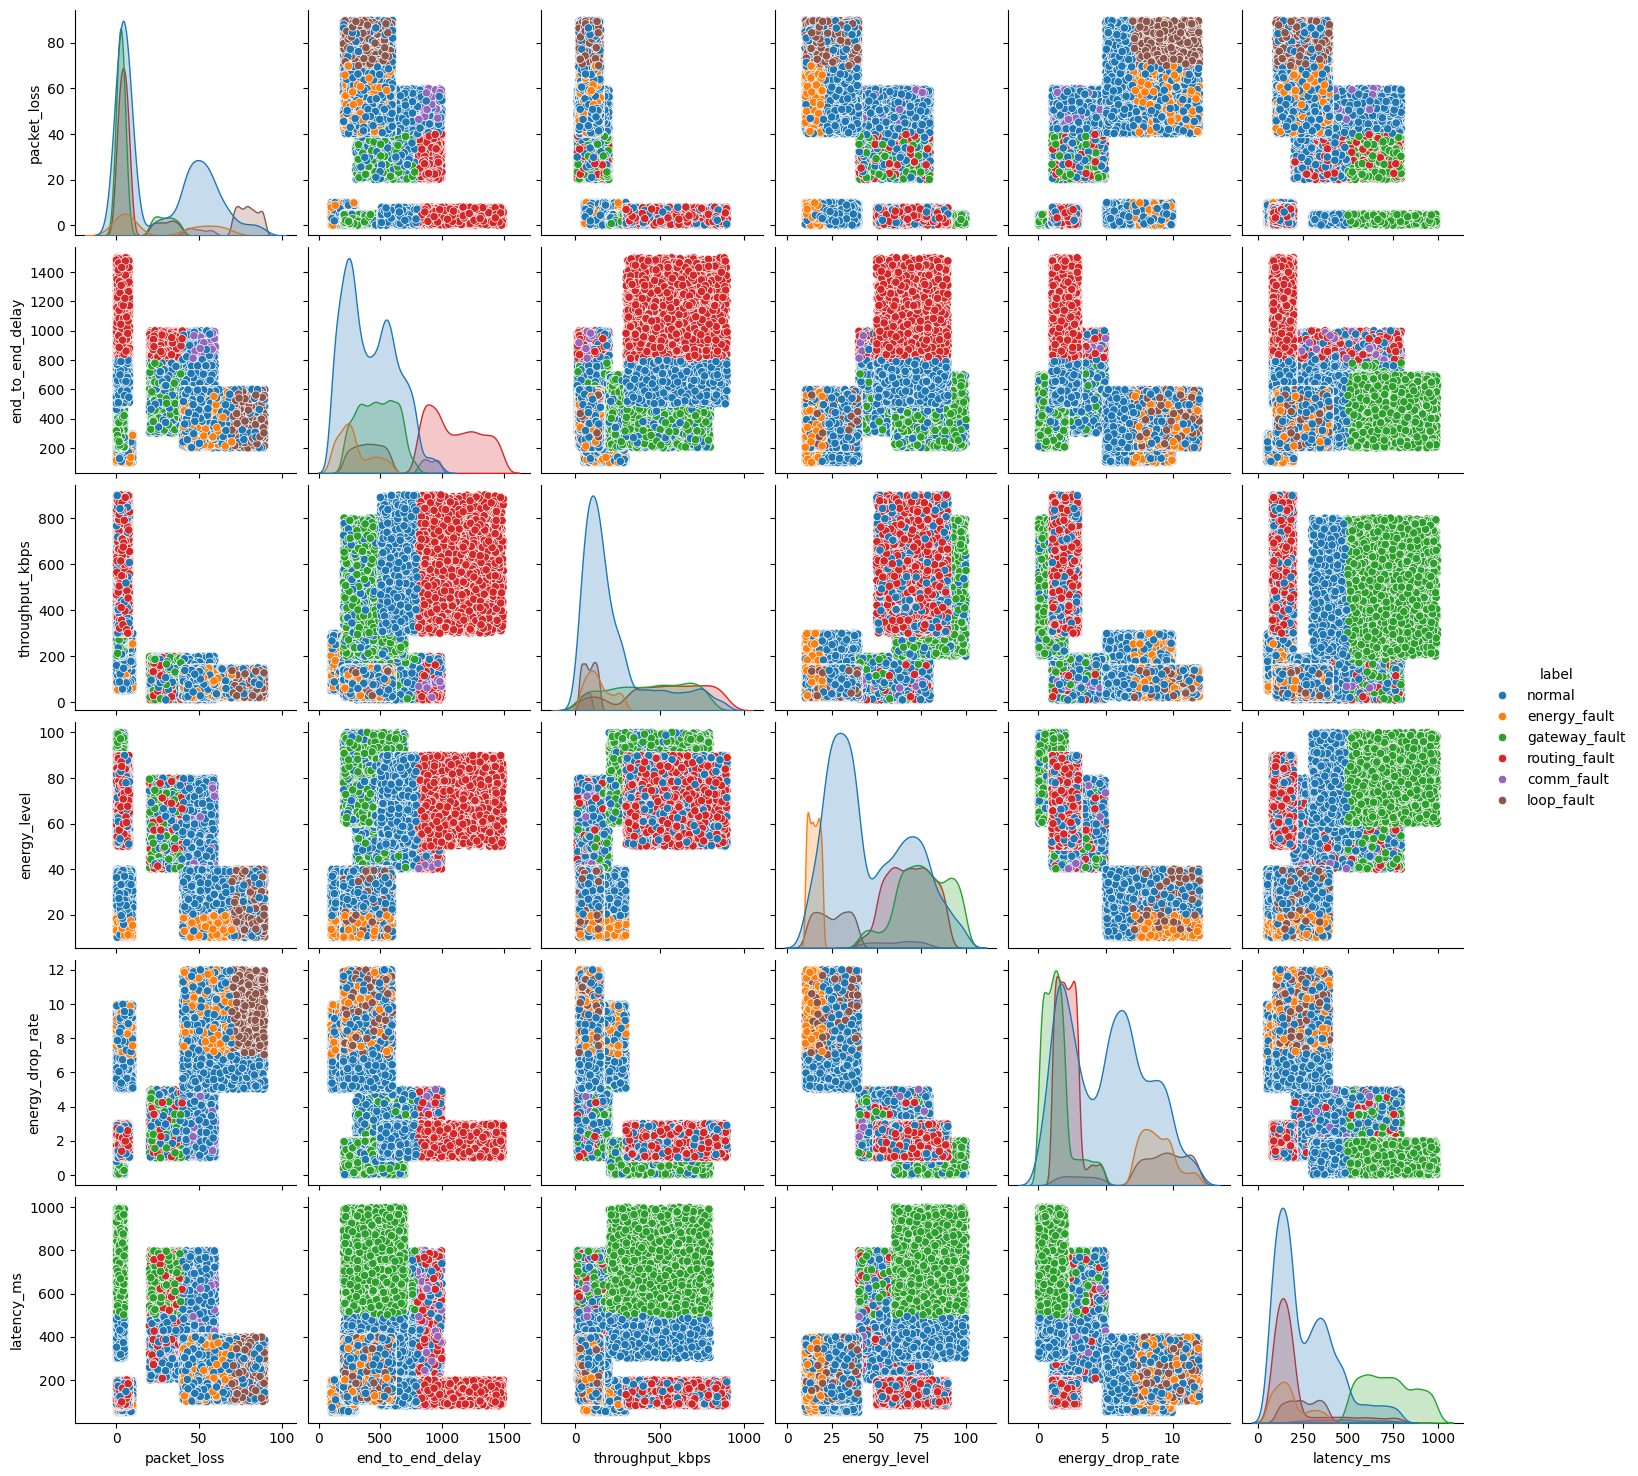


=== CEK KELAS KECIL (< 5% DATA) ===
label
comm_fault    0.012733
Name: proportion, dtype: float64

=== VALIDASI SELESAI ===


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ================================================================
# 1. LOAD DATASET BERLABEL
# ================================================================
df = pd.read_excel("dataset_labeled_wsn.xlsx")

print("=== Dataset Loaded ===")
print(df.head())


# ================================================================
# 2. CEK DISTRIBUSI LABEL
# ================================================================
print("\n=== DISTRIBUSI LABEL ===")
print(df["label"].value_counts())

plt.figure(figsize=(7,4))
df["label"].value_counts().plot(kind="bar", color="skyblue")
plt.title("Distribusi Label")
plt.xlabel("Label")
plt.ylabel("Jumlah Data")
plt.tight_layout()
plt.show()


# ================================================================
# 3. CEK APakah Ada Label Kosong atau Imbalance
# ================================================================
print("\n=== DISTRIBUSI (PERSENTASE) ===")
print(df["label"].value_counts(normalize=True) * 100)


# ================================================================
# 4. CEK STATISTIK TIAP LABEL
# ================================================================
print("\n=== STATISTIK SETIAP LABEL ===")
label_groups = df.groupby("label").mean(numeric_only=True)
print(label_groups)


# ================================================================
# 5. CEK KONFLIK RULE (MULTI-KLASIFIKASI)
# ================================================================
# DEFINISI ULANG RULE UNTUK VALIDASI

ENERGY_LOW = 20
ENERGY_DROP_HIGH = 7
PKT_LOSS_HIGH = 40
PKT_LOSS_VERY_HIGH = 70
THROUGHPUT_LOW = 100
DELAY_HIGH = 800
LATENCY_HIGH = 500

cond_loop_fault = (
    (df["packet_loss"] >= PKT_LOSS_VERY_HIGH) &
    (df["energy_drop_rate"] >= ENERGY_DROP_HIGH)
)

cond_energy_fault = (
    (df["energy_level"] <= ENERGY_LOW) &
    (df["energy_drop_rate"] >= ENERGY_DROP_HIGH)
)

cond_comm_fault = (
    (df["packet_loss"] >= PKT_LOSS_HIGH) &
    (df["throughput_kbps"] <= THROUGHPUT_LOW) &
    (df["end_to_end_delay"] >= DELAY_HIGH)
)

cond_routing_fault = (
    (df["end_to_end_delay"] >= DELAY_HIGH) &
    (df["packet_loss"] < PKT_LOSS_HIGH)
)

cond_gateway_fault = (
    (df["latency_ms"] >= LATENCY_HIGH) &
    (df["packet_loss"] < PKT_LOSS_HIGH)
)


print("\n=== CEK KONFLIK RULE ===")
conflict_rows = []

for i in range(len(df)):
    matches = []
    if cond_loop_fault.iloc[i]: matches.append("loop_fault")
    if cond_energy_fault.iloc[i]: matches.append("energy_fault")
    if cond_comm_fault.iloc[i]: matches.append("comm_fault")
    if cond_routing_fault.iloc[i]: matches.append("routing_fault")
    if cond_gateway_fault.iloc[i]: matches.append("gateway_fault")

    if len(matches) > 1:
        conflict_rows.append((i, matches))

if len(conflict_rows) == 0:
    print("Tidak ada konflik rule. ✔ Aman")
else:
    print("Konflik ditemukan:")
    print(conflict_rows[:10])  # tampilkan 10 konflik pertama


# ================================================================
# 6. CEK KOHERENSI LOGIKA LABEL
# ================================================================
print("\n=== CEK KOHERENSI LOGIKA LABEL ===")

def cek_logika(label, kondisi):
    salah = df[(df["label"] == label) & (~kondisi)]
    print(f"\n{label}: {len(salah)} data tidak sesuai indikator")
    return salah

# COMM FAULT harus punya loss tinggi + throughput rendah + delay tinggi
cek_logika("comm_fault",
           (df["packet_loss"] >= PKT_LOSS_HIGH) &
           (df["throughput_kbps"] <= THROUGHPUT_LOW) &
           (df["end_to_end_delay"] >= DELAY_HIGH))

# ENERGY FAULT harus energi rendah + drop rate tinggi
cek_logika("energy_fault",
           (df["energy_level"] <= ENERGY_LOW) &
           (df["energy_drop_rate"] >= ENERGY_DROP_HIGH))

# ROUTING FAULT harus delay tinggi + loss rendah
cek_logika("routing_fault",
           (df["end_to_end_delay"] >= DELAY_HIGH) &
           (df["packet_loss"] < PKT_LOSS_HIGH))

# LOOP FAULT harus loss sangat tinggi + drop rate tinggi
cek_logika("loop_fault",
           (df["packet_loss"] >= PKT_LOSS_VERY_HIGH) &
           (df["energy_drop_rate"] >= ENERGY_DROP_HIGH))

# GATEWAY FAULT harus latency tinggi + loss tidak parah
cek_logika("gateway_fault",
           (df["latency_ms"] >= LATENCY_HIGH) &
           (df["packet_loss"] < PKT_LOSS_HIGH))


# ================================================================
# 7. CEK VARIASI FITUR DALAM SETIAP LABEL (APAKAH CUKUP BERBEDA?)
# ================================================================
plt.figure(figsize=(10,6))
sns.pairplot(df[["packet_loss","end_to_end_delay","throughput_kbps",
                 "energy_level","energy_drop_rate","latency_ms","label"]],
             hue="label")
plt.show()


# ================================================================
# 8. CEK ADANYA LABEL YANG TERLALU SEDIKIT
# ================================================================
print("\n=== CEK KELAS KECIL (< 5% DATA) ===")
small_classes = df["label"].value_counts(normalize=True)[df["label"].value_counts(normalize=True) < 0.05]
print(small_classes)


print("\n=== VALIDASI SELESAI ===")


=== 5 Baris Pertama Dataset Berlabel ===
   energy_level  energy_drop_rate  latency_ms  end_to_end_delay  packet_loss  \
0     21.236204          9.753572  159.799091        219.731697     1.560186   
1     23.777467          6.668543   71.430023        230.177695     0.564116   
2     16.370173          5.909125   77.510676        160.848449     5.247564   
3     25.743240          6.999305   56.999849        294.751104     2.327713   
4     15.990213          7.571172  138.862185        109.290083     6.075449   

   throughput_kbps         label  
0        88.998630        normal  
1       230.499693        normal  
2       157.986255        normal  
3        72.651609        normal  
4        92.631031  energy_fault  

Kolom yang tersedia: ['energy_level', 'energy_drop_rate', 'latency_ms', 'end_to_end_delay', 'packet_loss', 'throughput_kbps', 'label']

Distribusi label (seluruh dataset):
Counter({'normal': 7735, 'gateway_fault': 2684, 'routing_fault': 2535, 'energy_fault': 1030, 'l

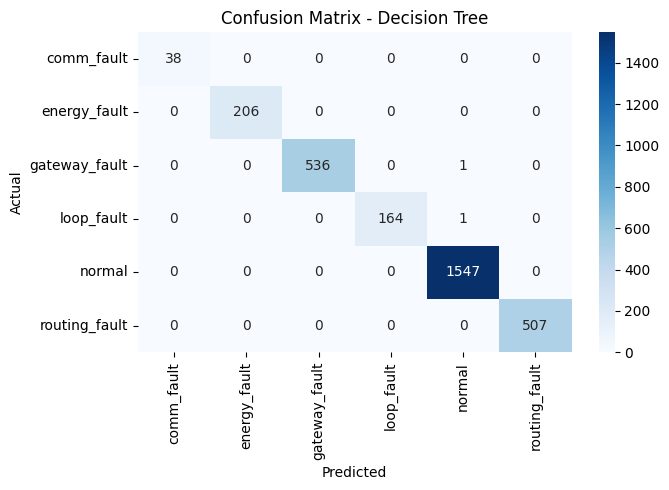

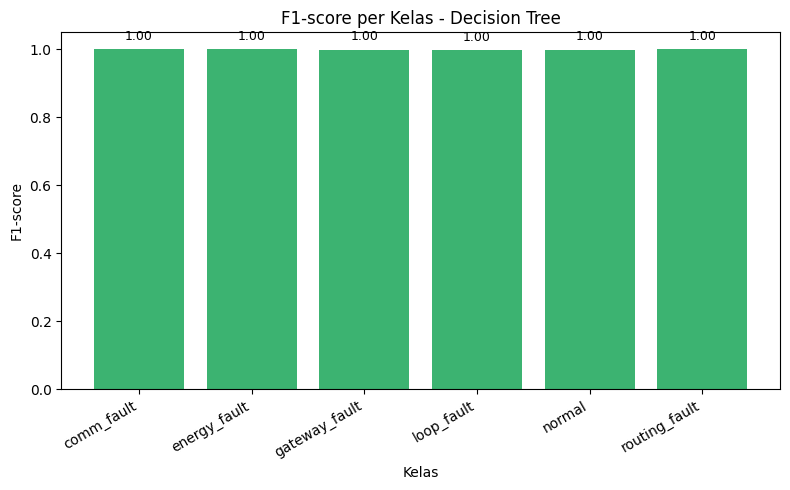


================= Random Forest =================
Akurasi: 0.9993

Classification Report:
               precision    recall  f1-score   support

   comm_fault       1.00      1.00      1.00        38
 energy_fault       1.00      1.00      1.00       206
gateway_fault       1.00      1.00      1.00       537
   loop_fault       1.00      0.99      1.00       165
       normal       1.00      1.00      1.00      1547
routing_fault       1.00      1.00      1.00       507

     accuracy                           1.00      3000
    macro avg       1.00      1.00      1.00      3000
 weighted avg       1.00      1.00      1.00      3000

Confusion Matrix (raw):
[[  38    0    0    0    0    0]
 [   0  206    0    0    0    0]
 [   0    0  536    0    1    0]
 [   0    0    0  164    1    0]
 [   0    0    0    0 1547    0]
 [   0    0    0    0    0  507]]


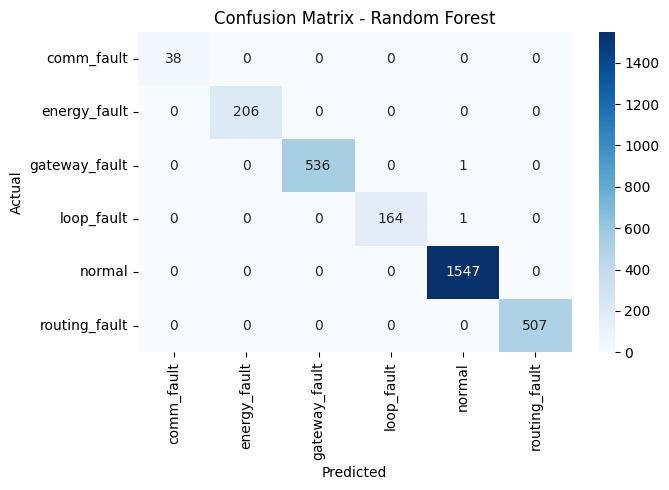

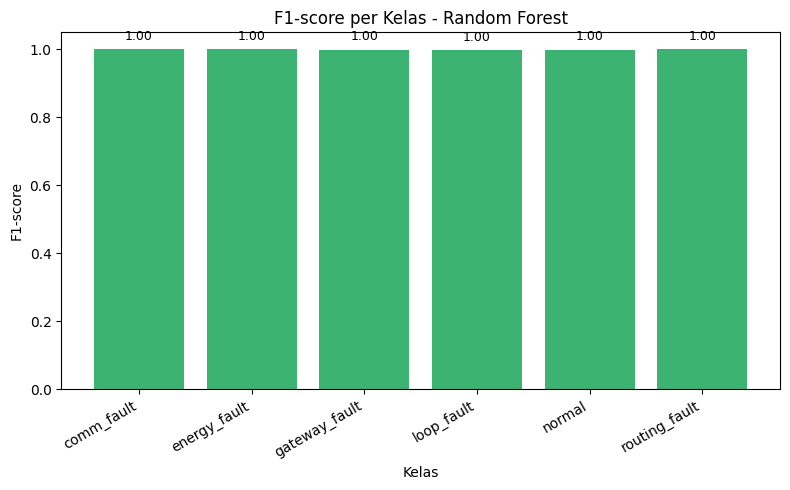


================= Gradient Boosting =================
Akurasi: 0.9993

Classification Report:
               precision    recall  f1-score   support

   comm_fault       1.00      1.00      1.00        38
 energy_fault       1.00      1.00      1.00       206
gateway_fault       1.00      1.00      1.00       537
   loop_fault       1.00      0.99      1.00       165
       normal       1.00      1.00      1.00      1547
routing_fault       1.00      1.00      1.00       507

     accuracy                           1.00      3000
    macro avg       1.00      1.00      1.00      3000
 weighted avg       1.00      1.00      1.00      3000

Confusion Matrix (raw):
[[  38    0    0    0    0    0]
 [   0  206    0    0    0    0]
 [   0    0  536    0    1    0]
 [   0    0    0  164    1    0]
 [   0    0    0    0 1547    0]
 [   0    0    0    0    0  507]]


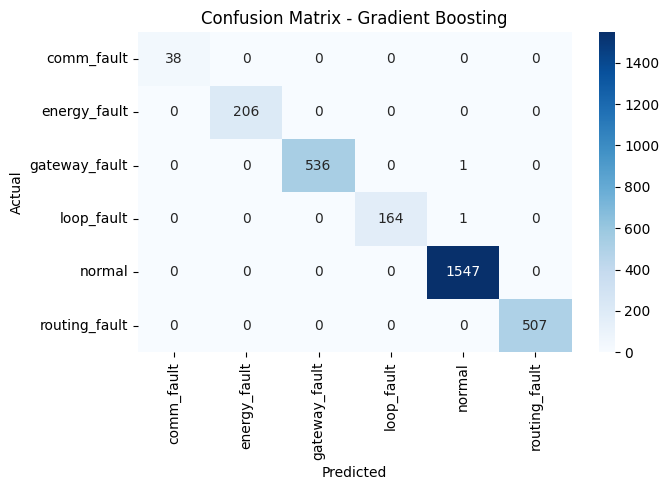

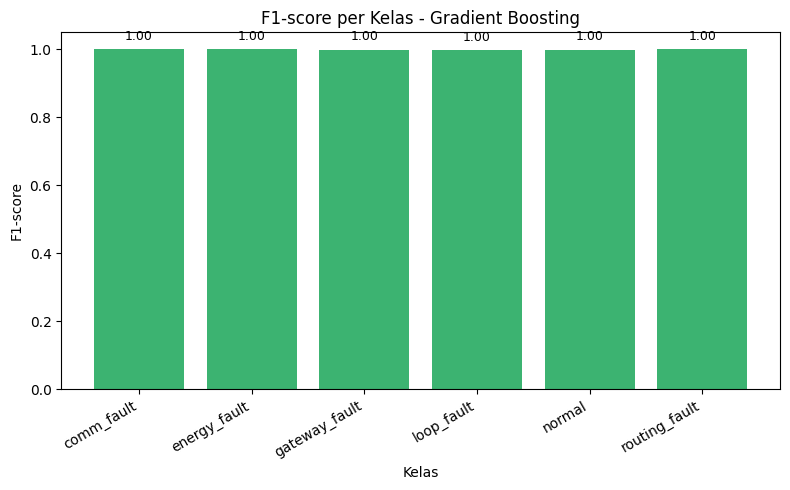


================= Extra Trees =================
Akurasi: 0.9900

Classification Report:
               precision    recall  f1-score   support

   comm_fault       0.90      0.97      0.94        38
 energy_fault       0.97      1.00      0.98       206
gateway_fault       0.99      0.99      0.99       537
   loop_fault       0.98      1.00      0.99       165
       normal       1.00      0.99      0.99      1547
routing_fault       0.99      1.00      0.99       507

     accuracy                           0.99      3000
    macro avg       0.97      0.99      0.98      3000
 weighted avg       0.99      0.99      0.99      3000

Confusion Matrix (raw):
[[  37    0    0    0    1    0]
 [   0  205    0    0    1    0]
 [   0    0  532    0    4    1]
 [   0    0    0  165    0    0]
 [   4    7    4    3 1524    5]
 [   0    0    0    0    0  507]]


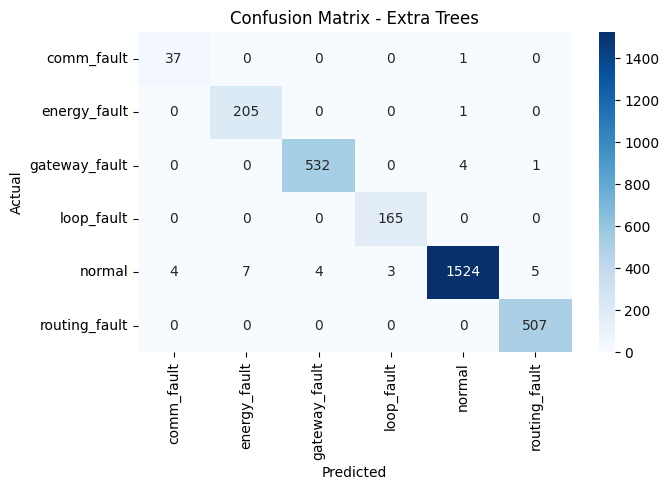

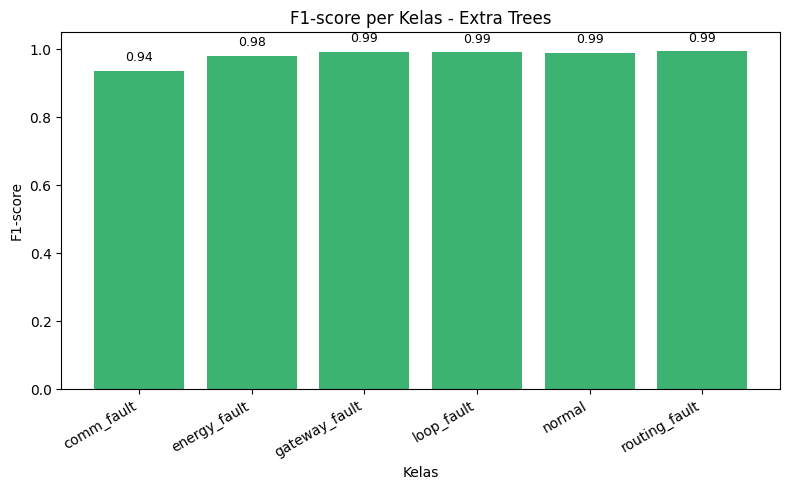


=== RINGKASAN METRIK MODEL ===
               Model  Accuracy  F1_macro  Precision_macro  Recall_macro
0      Decision Tree  0.999333  0.999230         0.999785      0.998680
1      Random Forest  0.999333  0.999230         0.999785      0.998680
2  Gradient Boosting  0.999333  0.999230         0.999785      0.998680
3        Extra Trees  0.990000  0.980811         0.971414      0.990775


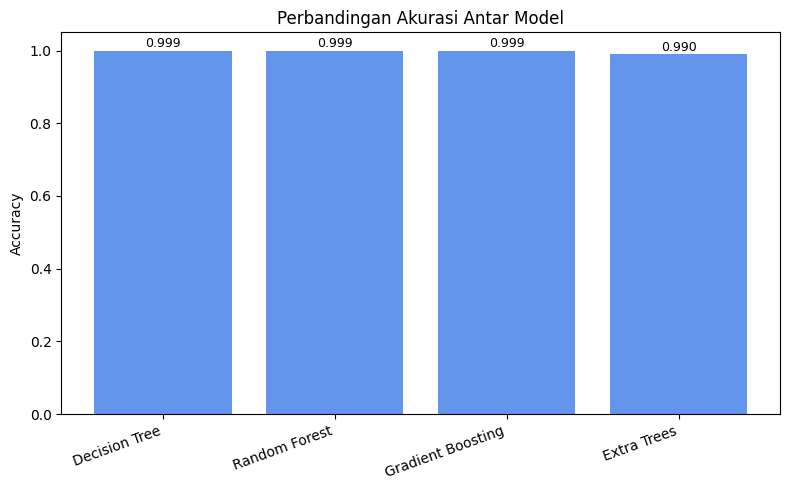

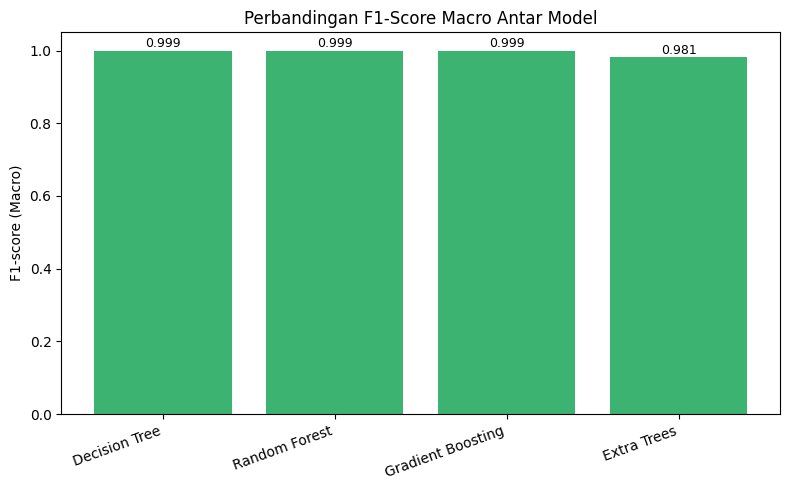


=== MODEL TERBAIK SEMENTARA: Decision Tree ===
Akurasi: 0.9993

=== FEATURE IMPORTANCE - RANDOM FOREST ===
            feature  importance
4       packet_loss    0.293484
3  end_to_end_delay    0.207891
2        latency_ms    0.150876
0      energy_level    0.150575
1  energy_drop_rate    0.120746
5   throughput_kbps    0.076427


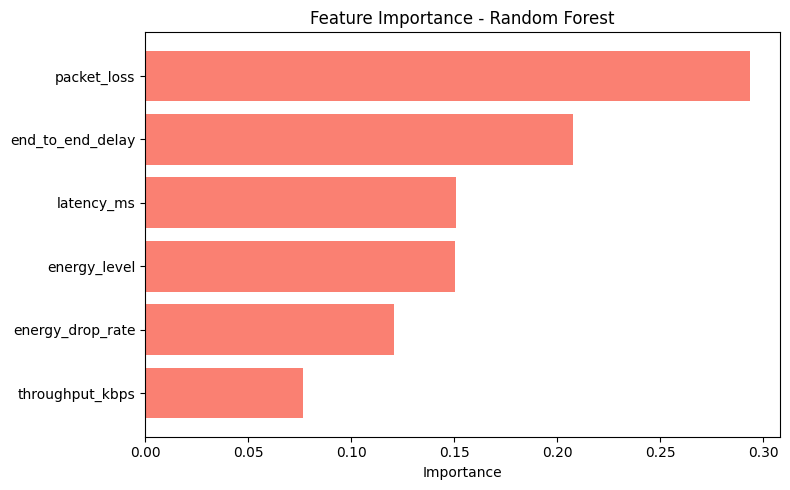

In [2]:
# ============================================
# PIPELINE TRAINING FINAL + VISUAL + FEATURE IMPORTANCE
# - Load data berlabel
# - Train-test split (stratified)
# - Normalisasi (fit di train saja)
# - SMOTE di train
# - Training DT, RF, Gradient Boosting, ExtraTrees
# - Evaluasi + Confusion Matrix + F1 per kelas
# - Ringkasan visual akurasi & F1 macro
# - Feature importance Random Forest
# ============================================

import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    ExtraTreesClassifier
)

from imblearn.over_sampling import SMOTE

# ============================================================
# 1. LOAD DATASET BERLABEL (MENTAH, BELUM DINORMALISASI)
# ============================================================
df = pd.read_excel("dataset_labeled_wsn.xlsx")

print("=== 5 Baris Pertama Dataset Berlabel ===")
print(df.head())
print("\nKolom yang tersedia:", df.columns.tolist())

# Fitur = semua kecuali 'label'
X = df.drop(columns=["label"])
y = df["label"]

print("\nDistribusi label (seluruh dataset):")
print(Counter(y))


# ============================================================
# 2. TRAIN–TEST SPLIT (STRATIFIED)
# ============================================================
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y     # jaga proporsi label
)

print("\nDistribusi label di TRAIN (sebelum SMOTE):")
print(Counter(y_train))

print("\nDistribusi label di TEST:")
print(Counter(y_test))


# ============================================================
# 3. NORMALISASI FITUR (TANPA DATA LEAKAGE)
# ============================================================
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

print("\nContoh X_train_scaled (5 baris):")
print(X_train_scaled[:5])


# ============================================================
# 4. SMOTE DI DATA TRAINING SAJA
# ============================================================
print("\n=== SMOTE: balancing data training ===")
print("Sebelum SMOTE:", Counter(y_train))

smote = SMOTE(random_state=42, k_neighbors=5)
X_train_bal, y_train_bal = smote.fit_resample(X_train_scaled, y_train)

print("Sesudah SMOTE:", Counter(y_train_bal))


# ============================================================
# 5. DEFINISI MODEL (SEMUA TREE-BASED)
# ============================================================
models = {
    "Decision Tree": DecisionTreeClassifier(
        random_state=42
    ),
    "Random Forest": RandomForestClassifier(
        n_estimators=200,
        random_state=42,
        n_jobs=-1
    ),
    "Gradient Boosting": GradientBoostingClassifier(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=3,
        random_state=42
    ),
    "Extra Trees": ExtraTreesClassifier(
        n_estimators=200,
        random_state=42,
        n_jobs=-1
    )
}

results = {}

label_order = sorted(y.unique())  # supaya urutan kelas konsisten

def plot_confusion(cm, labels, title):
    plt.figure(figsize=(7,5))
    sns.heatmap(cm, annot=True, fmt="d",
                xticklabels=labels,
                yticklabels=labels,
                cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.tight_layout()
    plt.show()

def plot_f1_bar(report_dict, title):
    class_names = []
    f1_scores = []
    for k, v in report_dict.items():
        if k in ["accuracy", "macro avg", "weighted avg"]:
            continue
        class_names.append(k)
        f1_scores.append(v["f1-score"])

    plt.figure(figsize=(8,5))
    bars = plt.bar(class_names, f1_scores, color="mediumseagreen")
    plt.ylim(0,1.05)
    plt.title(title)
    plt.ylabel("F1-score")
    plt.xlabel("Kelas")
    plt.xticks(rotation=30, ha="right")

    for bar, score in zip(bars, f1_scores):
        plt.text(bar.get_x() + bar.get_width()/2,
                 bar.get_height() + 0.02,
                 f"{score:.2f}",
                 ha="center", va="bottom", fontsize=9)

    plt.tight_layout()
    plt.show()


# ============================================================
# 6. TRAINING & EVALUASI PER MODEL (PLUS VISUAL)
# ============================================================
for name, model in models.items():
    print(f"\n================= {name} =================")
    
    # Train pakai TRAIN balanced (SMOTE)
    model.fit(X_train_bal, y_train_bal)

    # Prediksi di TEST (asli)
    y_pred = model.predict(X_test_scaled)

    # Akurasi
    acc = accuracy_score(y_test, y_pred)
    print(f"Akurasi: {acc:.4f}")

    # Classification report untuk metrik & plotting
    report_dict = classification_report(
        y_test, y_pred,
        target_names=label_order,
        output_dict=True
    )
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=label_order))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=label_order)
    print("Confusion Matrix (raw):")
    print(cm)

    # Simpan metrik ringkas
    results[name] = {
        "model": model,
        "accuracy": acc,
        "cm": cm,
        "report": report_dict,
        "f1_macro": report_dict["macro avg"]["f1-score"],
        "precision_macro": report_dict["macro avg"]["precision"],
        "recall_macro": report_dict["macro avg"]["recall"],
    }

    # 🔹 Visual 1: Confusion Matrix berwarna
    plot_confusion(cm, labels=label_order, title=f"Confusion Matrix - {name}")

    # 🔹 Visual 2: Bar chart F1-score per kelas
    plot_f1_bar(report_dict, title=f"F1-score per Kelas - {name}")


# ============================================================
# 7. RINGKASAN PERBANDINGAN MODEL (TABEL & GRAFIK)
# ============================================================
summary_rows = []
for name, info in results.items():
    summary_rows.append({
        "Model": name,
        "Accuracy": info["accuracy"],
        "F1_macro": info["f1_macro"],
        "Precision_macro": info["precision_macro"],
        "Recall_macro": info["recall_macro"],
    })

summary_df = pd.DataFrame(summary_rows)
print("\n=== RINGKASAN METRIK MODEL ===")
print(summary_df)

# 🔹 Plot perbandingan Akurasi
plt.figure(figsize=(8,5))
plt.bar(summary_df["Model"], summary_df["Accuracy"], color="cornflowerblue")
plt.ylim(0, 1.05)
plt.title("Perbandingan Akurasi Antar Model")
plt.ylabel("Accuracy")
plt.xticks(rotation=20, ha="right")
for i, v in enumerate(summary_df["Accuracy"]):
    plt.text(i, v + 0.01, f"{v:.3f}", ha="center", fontsize=9)
plt.tight_layout()
plt.show()

# 🔹 Plot perbandingan F1 Macro
plt.figure(figsize=(8,5))
plt.bar(summary_df["Model"], summary_df["F1_macro"], color="mediumseagreen")
plt.ylim(0, 1.05)
plt.title("Perbandingan F1-Score Macro Antar Model")
plt.ylabel("F1-score (Macro)")
plt.xticks(rotation=20, ha="right")
for i, v in enumerate(summary_df["F1_macro"]):
    plt.text(i, v + 0.01, f"{v:.3f}", ha="center", fontsize=9)
plt.tight_layout()
plt.show()


# ============================================================
# 8. PILIH MODEL TERBAIK (BERDASARKAN AKURASI)
# ============================================================
best_model_name = max(results, key=lambda m: results[m]["accuracy"])
best_model = results[best_model_name]["model"]

print(f"\n=== MODEL TERBAIK SEMENTARA: {best_model_name} ===")
print(f"Akurasi: {results[best_model_name]['accuracy']:.4f}")


# ============================================================
# 9. FEATURE IMPORTANCE RANDOM FOREST
# ============================================================
if "Random Forest" in results:
    rf_model = results["Random Forest"]["model"]
    feature_names = X.columns
    importances = rf_model.feature_importances_

    fi_df = pd.DataFrame({
        "feature": feature_names,
        "importance": importances
    }).sort_values("importance", ascending=False)

    print("\n=== FEATURE IMPORTANCE - RANDOM FOREST ===")
    print(fi_df)

    # Visual
    plt.figure(figsize=(8,5))
    plt.barh(fi_df["feature"], fi_df["importance"], color="salmon")
    plt.xlabel("Importance")
    plt.title("Feature Importance - Random Forest")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
else:
    print("\nRandom Forest tidak ditemukan di results, tidak bisa hitung feature importance.")
